<a href="https://colab.research.google.com/github/andygoosh/wildfire.sberbank.ai/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
'''
#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")

plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
#tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  old_rcparam = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (18,6)


  plt.subplot(1,3,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.legend()

  plt.subplot(1,3,2)
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.plot(hist['epoch'], hist['auc'],
           label='Train AUC')
  plt.plot(hist['epoch'], hist['val_auc'],
           label = 'Val AUC')
  plt.legend()
  
  plt.subplot(1,3,3)
  plt.xlabel('Epoch')
  plt.ylabel('Categorical Acc')
  plt.plot(hist['epoch'], hist['categorical_accuracy'],
           label='Train cat.acc.')
  plt.plot(hist['epoch'], hist['val_categorical_accuracy'],
           label = 'Val cat.acc.')
  plt.legend()
  
  plt.show()

  plt.rcParams["figure.figsize"] = old_rcparam


Populating the interactive namespace from numpy and matplotlib


1.15.0
2.2.4-tf


Using TensorFlow backend.


In [0]:
def prepare_data(one_hotted=False):

  df_features = pd.read_csv('fts_preprocessed.cvs', index_col='fire_id')
  FTS = df_features.columns[3:]
  TARGET = 'fire_type'

  columns = [TARGET]

  X = df_features[FTS].fillna(0)
  if one_hotted == True:
    y = get_one_hot( df_features[TARGET] )
  else:
    y = df_features[TARGET]

  return X, y


In [0]:
def reduce_dimentions( X, draw_graph=False ):
  pca = PCA()
  pca.fit(X)
  t = pca.transform(X)

  cols = [f"f{i:d}" for i in range(t.shape[1])]
  X = pd.DataFrame(t, index=X.index, columns=cols)

  if( draw_graph == True):
    feat_importances = pd.Series(pca.explained_variance_, index=X.columns)
    feat_importances.plot(kind='barh')

  return X

In [0]:
def get_one_hot( y ):
  columns=[ 'fire_{}_prob'.format(i) for i in range(1, 12) ]
  columns.remove('fire_7_prob')
  y_ = y.values.reshape(-1,1)
  enc = OneHotEncoder().fit(y_)

  return pd.DataFrame(enc.transform(y_).toarray(), index=y.index, columns=columns)

In [0]:
def draw_confusion_matrix( gt, pred, model ):
  # get rid of probability, set max prob to 1, erst to 0
  pred_max_prob = pred.apply(lambda row: row.map(lambda e: 1 if e == row.max() else 0), axis = 1)
  # do the trick
  cnf_matrix = skl.metrics.confusion_matrix(pred_max_prob.values.argmax(axis=1), gt.values.argmax(axis=1))
  class_names=pred.columns
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1)
  plt.ylabel('Predicted label')
  plt.xlabel('Actual label')

  auc = skl.metrics.roc_auc_score(gt, pred, average='micro')
  str = '{}: CV ROC AUC={:.3f}'.format(type(model).__name__, auc )
  plt.title(str, y=1)
  print(str)

## NCEP Dataset

Погодные данные из проекта [NCEP Reanalysis 2](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html) — усреднённые за день температура воздуха, относительная влажность и компоненты ветра. Данные можно получить с 1979 года.

Загрузите наборы данных в каталог `data/ncep/`:
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc

In [73]:
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc


--2019-11-24 06:59:46--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46055656 (44M) [application/x-netcdf]
Saving to: ‘rhum.2018.nc’

rhum.2018.nc        100%[===================>]  43.92M  1.07MB/s    in 54s     

2019-11-24 07:00:40 (830 KB/s) - ‘rhum.2018.nc’ saved [46055656/46055656]

--2019-11-24 07:00:42--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92099952 (88M) [application/x-netcdf]
Saving to: ‘uwnd.2018.nc’

uwnd.2018.nc        100%[===================>]  87.8

In [75]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = '{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename,),)
ncep_data = xarray.merge(ncep_data)

/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


## Набор признаков на основе данных NCEP

Ищем наиболее близкий к точке узел сетки в наборе NCEP, в качестве признаков значения переменных зарегистрированные в день регистрации точки и агрегированные показатели за период от 1 до 3х недель до момента регистрации точки.

In [0]:
def extract_features(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    date = row['date']
    v = point.sel(time=date)

    PERIODS = [7, 14, 21, 28]
    AGGREGATES = ["mean", "median", "std", "max", "min"]
    all_features = {
        'fire_id': row['fire_id'],
        'fire_type': row['fire_type'], # change for '' while submitting
        'fire_type_name': row['fire_type_name'], # change for '' while submitting
        'date': row['date'], 
        'day': int(date.split('-')[1]),
        'month': int(date.split('-')[2]),
        'longitude': row['longitude'],
        'latitude': row['latitude'],
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0)
    }

    for period in PERIODS:
        rolling_features = point.rolling(time=period)
        for agg in AGGREGATES:
            agg_function = getattr(rolling_features, agg)
            rolling_result = agg_function().sel(time=date)

            name_t = "_".join(['t', str(period), agg])
            all_features[name_t] = rolling_result.air.values.item(0)

            name_h = "_".join(['h', str(period), agg])
            all_features[name_h] = rolling_result.rhum.values.item(0)

            name_u = "_".join(['u', str(period), agg])
            all_features[name_u] = rolling_result.uwnd.values.item(0)

    return all_features

## Подготовка выборки для обучения

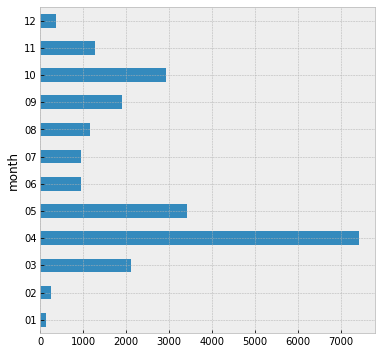

In [41]:
a = pd.read_csv('wildfires_train.csv')
a = a.query('(date > "2018") & (date < "2019")')

a['month'] = a.date.map(lambda x: x.split('-')[1])

b = a.fire_id.groupby(a.month).count()
b.plot.barh()

In [43]:
a

,fire_id,date,latitude,longitude,fire_type,fire_type_name,month
136040,136040,2018-01-01,55.902280,98.080232,3,горение мусора,01
136041,136041,2018-01-01,54.216790,87.565010,9,природный пожар,01
136042,136042,2018-01-01,56.961032,97.716761,3,горение мусора,01
136043,136043,2018-01-01,52.456409,113.301796,4,сжигание порубочных остатков,01
136044,136044,2018-01-02,50.798930,108.130196,4,сжигание порубочных остатков,01
...,...,...,...,...,...,...,...
158855,158855,2018-12-29,43.740941,131.300458,6,неконтролируемый пал,12
158856,158856,2018-12-29,42.684450,131.223432,6,неконтролируемый пал,12
158857,158857,2018-12-29,44.287796,132.428538,6,неконтролируемый пал,12
158858,158858,2018-12-29,43.483922,131.859177,6,неконтролируемый пал,12


In [111]:
df_train = pd.read_csv('wildfires_train.csv')
#df_subsample = df_train.query('(date > "2018") & (date < "2019")').sample(n=8000, random_state=RS)
df_subsample = df_train.query('(date > "2018") & (date < "2019")')

'''
df_subsample = df_train.query('(date > "2018") & (date < "2019")')
min_samples_num = 400
b = []
for i in range(1, 12):
  query_res = df_subsample.query('fire_type == %d' % i)
  num_samples = min_samples_num
  if query_res.shape[0] < num_samples:
    num_samples = query_res.shape[0]

  c = query_res.sample(num_samples, random_state=RS)
  b.append(c)

df_subsample = pd.concat(b)
'''

df_features = []
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):

    features = extract_features(row)
    df_features.append(features)

df_features = pd.DataFrame(df_features)
df_features.set_index('fire_id', inplace=True)
df_features.to_csv('fts_preprocessed.cvs', index_label='fire_id')

In [99]:
df_features

,fire_type,fire_type_name,date,day,month,longitude,latitude,temperature,humidity,uwind,t_7_mean,h_7_mean,u_7_mean,t_7_median,h_7_median,u_7_median,t_7_std,h_7_std,u_7_std,t_7_max,h_7_max,u_7_max,t_7_min,h_7_min,u_7_min,t_14_mean,h_14_mean,u_14_mean,t_14_median,h_14_median,u_14_median,t_14_std,h_14_std,u_14_std,t_14_max,h_14_max,u_14_max,t_14_min,h_14_min,u_14_min,t_21_mean,h_21_mean,u_21_mean,t_21_median,h_21_median,u_21_median,t_21_std,h_21_std,u_21_std,t_21_max,h_21_max,u_21_max,t_21_min,h_21_min,u_21_min,t_28_mean,h_28_mean,u_28_mean,t_28_median,h_28_median,u_28_median,t_28_std,h_28_std,u_28_std,t_28_max,h_28_max,u_28_max,t_28_min,h_28_min,u_28_min
fire_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156306,4,сжигание порубочных остатков,2018-10-19,10,19,32.817378,53.629106,289.489990,62.210007,1.099991,288.611420,56.221474,1.578568,289.099976,57.770004,1.099991,1.734554,4.974678,1.374208,291.149994,62.210007,3.569992,286.390015,46.399994,-0.410004,286.483215,62.770710,1.447140,286.174988,62.125000,1.399994,2.706630,8.180873,2.012869,291.149994,75.089996,4.690002,281.049988,46.399994,-3.050003,285.048981,65.120476,2.008093,285.209991,66.500000,1.699997,3.142212,8.591250,2.335866,291.149994,77.240005,7.869995,279.700012,46.399994,-3.050003,285.043488,67.059662,2.660355,284.695007,69.195000,2.599998,3.574846,9.435399,2.524624,295.260010,81.539993,7.869995,279.700012,46.399994,-3.050003
141151,11,не подтверждено,2018-04-14,4,14,33.288874,55.158507,280.979980,47.699997,-1.940002,281.634338,52.944279,-0.521432,280.880005,55.779999,-0.660004,3.122652,7.996476,2.458827,287.950012,61.830002,3.099991,277.940002,37.980011,-4.089996,279.822144,69.292854,-0.157146,279.744995,64.830002,-0.605003,3.390145,18.253689,2.961337,287.950012,96.330002,4.889999,275.399994,37.980011,-4.720001,277.002838,72.166183,0.188092,277.279999,80.830002,0.289993,5.078269,17.716551,2.661560,287.950012,96.330002,4.889999,268.020020,37.980011,-4.720001,275.296112,73.953232,0.732140,275.335022,80.605003,0.610001,5.523023,15.691216,2.604454,287.950012,96.330002,5.169998,263.669983,37.980011,-4.720001
153769,10,контролируемый пал,2018-09-24,9,24,116.875240,62.923579,281.410004,77.190002,1.679993,280.072632,71.319992,1.664283,280.399994,68.949997,1.569992,1.147348,5.448310,1.343671,281.410004,79.589996,4.050003,278.339996,64.559998,-0.479996,279.706512,71.865730,0.107855,279.524994,69.004997,0.489998,1.252412,8.104973,2.225845,281.410004,88.169998,4.050003,277.289978,58.889999,-4.169998,279.004089,70.065742,0.313807,279.020020,68.759995,0.660004,1.789414,8.114033,2.145920,281.410004,88.169998,4.050003,275.160004,58.889999,-4.169998,280.699677,71.038925,0.507855,279.524994,69.004997,0.994995,4.011778,8.468513,1.984817,290.890015,88.169998,4.050003,275.160004,58.800003,-4.169998
143153,11,не подтверждено,2018-04-21,4,21,38.099304,55.747030,287.299988,65.729996,5.389999,285.175781,62.898563,2.214284,284.450012,65.729996,2.029999,2.187356,11.030473,1.694622,288.839996,75.449997,5.389999,282.649994,41.769989,0.059998,282.556396,59.942188,1.343570,282.815002,63.324997,1.864998,3.858957,10.717012,2.354969,288.839996,75.449997,5.389999,276.869995,40.109985,-2.970001,280.580414,69.169525,1.007142,279.209991,68.899994,1.699997,4.346039,16.241674,2.521338,288.839996,96.779999,5.389999,274.750000,40.109985,-3.020004,278.073547,71.722145,1.206784,277.589996,70.104996,1.599998,5.915634,15.934000,2.302690,288.839996,96.779999,5.389999,267.200012,40.109985,-3.020004
154105,10,контролируемый пал,2018-09-28,9,28,116.519039,63.220488,278.619995,80.929993,1.809998,281.326904,77.658554,1.902854,281.410004,77.190002,1.789993,1.305207,5.941737,1.229540,283.289978,89.149994,4.050003,278.619995,70.539993,-0.290009,280.565094,75.638588,1.224997,280.744995,75.464996,1.305000,1.373229,7.669961,1.202590,283.289978,89.149994,4.050003,278.339996,64.559998,-0.479996,279.581207,71.855263,0.202378,279.089996,70.539993,0.660004,1.922948,8.679314,2.003309,283.289978,89.14999

## Линейные алго

In [0]:
#e = y.groupby(y).count()
#e.plot.barh()
#e

## Подбор параметров

## Гридсерч

In [0]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV

X, y = prepare_data(one_hotted=False)
#StratifiedKFold

gb = skl.ensemble.GradientBoostingClassifier(random_state=RS)
ab = skl.ensemble.AdaBoostClassifier(random_state=RS)
# "loss":["deviance"]

parameters_ab = { 
    'n_estimators':np.linspace(1, 100, 10).astype(int), 
    'learning_rate':np.logspace(0, 100, 10), 
    }

parameters_gb = { 
    'n_estimators':[300, 400, 500, 700], 
    'learning_rate':[0.03, 0.035, 0.039], 
    'max_depth': [2, 3,4, 5], 
    'min_samples_split': [3, 10, 20, 50],
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    }

GS = GridSearchCV(ab, parameters_ab, cv=KFold( n_splits = 5, shuffle=True, random_state=RS),verbose=10, n_jobs=-1)
GS.fit(X, y)
print( GS.best_params_ )
print( GS.best_score_ )

RS = RandomizedSearchCV(gb, )

## Рандомайзед серч

In [88]:
skl.ensemble.GradientBoostingClassifier().get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [27]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   
import sklearn.ensemble

X, y = prepare_data(one_hotted=False)
#StratifiedKFold
#from xgboost import XGBClassifier
#LGBMClassifier

gb = skl.ensemble.GradientBoostingClassifier()

parameters_gb = { 
    'n_estimators': sp_randInt(10, 1000),  # 100
    'learning_rate': sp_randFloat(),  # 0.1
    'max_depth': sp_randInt(1, 10),  # 1.0
    'min_samples_split': sp_randInt(3, 50),
    "min_samples_leaf": sp_randFloat(0, 1),
    "subsample": sp_randFloat(),
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "loss": ["deviance", "exponential"]
    }

RS = RandomizedSearchCV(gb, 
                        param_distributions=parameters_gb, 
                        cv=2, 
                        verbose=1, 
                        n_iter=10, 
                        scoring='f1_micro',
                        n_jobs=-1)
RS.fit(X, y)
print( RS.best_params_ )
print( RS.best_score_ )

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.3min finished


{'criterion': 'friedman_mse', 'learning_rate': 0.012299611487293416, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.2471251936343346, 'min_samples_split': 42, 'n_estimators': 446, 'subsample': 0.8342330592302794}
0.48675


## Проверка результата поиска

In [103]:
X

,day,month,longitude,latitude,temperature,humidity,uwind,t_7_mean,h_7_mean,u_7_mean,t_7_median,h_7_median,u_7_median,t_7_std,h_7_std,u_7_std,t_7_max,h_7_max,u_7_max,t_7_min,h_7_min,u_7_min,t_14_mean,h_14_mean,u_14_mean,t_14_median,h_14_median,u_14_median,t_14_std,h_14_std,u_14_std,t_14_max,h_14_max,u_14_max,t_14_min,h_14_min,u_14_min,t_21_mean,h_21_mean,u_21_mean,t_21_median,h_21_median,u_21_median,t_21_std,h_21_std,u_21_std,t_21_max,h_21_max,u_21_max,t_21_min,h_21_min,u_21_min,t_28_mean,h_28_mean,u_28_mean,t_28_median,h_28_median,u_28_median,t_28_std,h_28_std,u_28_std,t_28_max,h_28_max,u_28_max,t_28_min,h_28_min,u_28_min
fire_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156306,10,19,32.817378,53.629106,289.489990,62.210007,1.099991,288.611420,56.221474,1.578568,289.099976,57.770004,1.099991,1.734554,4.974678,1.374208,291.149994,62.210007,3.569992,286.390015,46.399994,-0.410004,286.483215,62.770710,1.447140,286.174988,62.125000,1.399994,2.706630,8.180873,2.012869,291.149994,75.089996,4.690002,281.049988,46.399994,-3.050003,285.048981,65.120476,2.008093,285.209991,66.500000,1.699997,3.142212,8.591250,2.335866,291.149994,77.240005,7.869995,279.700012,46.399994,-3.050003,285.043488,67.059662,2.660355,284.695007,69.195000,2.599998,3.574846,9.435399,2.524624,295.260010,81.539993,7.869995,279.700012,46.399994,-3.050003
141151,4,14,33.288874,55.158507,280.979980,47.699997,-1.940002,281.634338,52.944279,-0.521432,280.880005,55.779999,-0.660004,3.122652,7.996476,2.458827,287.950012,61.830002,3.099991,277.940002,37.980011,-4.089996,279.822144,69.292854,-0.157146,279.744995,64.830002,-0.605003,3.390145,18.253689,2.961337,287.950012,96.330002,4.889999,275.399994,37.980011,-4.720001,277.002838,72.166183,0.188092,277.279999,80.830002,0.289993,5.078269,17.716551,2.661560,287.950012,96.330002,4.889999,268.020020,37.980011,-4.720001,275.296112,73.953232,0.732140,275.335022,80.605003,0.610001,5.523023,15.691216,2.604454,287.950012,96.330002,5.169998,263.669983,37.980011,-4.720001
153769,9,24,116.875240,62.923579,281.410004,77.190002,1.679993,280.072632,71.319992,1.664283,280.399994,68.949997,1.569992,1.147348,5.448310,1.343671,281.410004,79.589996,4.050003,278.339996,64.559998,-0.479996,279.706512,71.865730,0.107855,279.524994,69.004997,0.489998,1.252412,8.104973,2.225845,281.410004,88.169998,4.050003,277.289978,58.889999,-4.169998,279.004089,70.065742,0.313807,279.020020,68.759995,0.660004,1.789414,8.114033,2.145920,281.410004,88.169998,4.050003,275.160004,58.889999,-4.169998,280.699677,71.038925,0.507855,279.524994,69.004997,0.994995,4.011778,8.468513,1.984817,290.890015,88.169998,4.050003,275.160004,58.800003,-4.169998
143153,4,21,38.099304,55.747030,287.299988,65.729996,5.389999,285.175781,62.898563,2.214284,284.450012,65.729996,2.029999,2.187356,11.030473,1.694622,288.839996,75.449997,5.389999,282.649994,41.769989,0.059998,282.556396,59.942188,1.343570,282.815002,63.324997,1.864998,3.858957,10.717012,2.354969,288.839996,75.449997,5.389999,276.869995,40.109985,-2.970001,280.580414,69.169525,1.007142,279.209991,68.899994,1.699997,4.346039,16.241674,2.521338,288.839996,96.779999,5.389999,274.750000,40.109985,-3.020004,278.073547,71.722145,1.206784,277.589996,70.104996,1.599998,5.915634,15.934000,2.302690,288.839996,96.779999,5.389999,267.200012,40.109985,-3.020004
154105,9,28,116.519039,63.220488,278.619995,80.929993,1.809998,281.326904,77.658554,1.902854,281.410004,77.190002,1.789993,1.305207,5.941737,1.229540,283.289978,89.149994,4.050003,278.619995,70.539993,-0.290009,280.565094,75.638588,1.224997,280.744995,75.464996,1.305000,1.373229,7.669961,1.202590,283.289978,89.149994,4.050003,278.339996,64.559998,-0.479996,279.581207,71.855263,0.202378,279.089996,70.539993,0.660004,1.922948,8.679314,2.003309,283.289978,89.149994,4.050003,275.160004,58.889999,-4.169998,279.566467,71.115707,0.575712,279.065002,69.004997,1.205002,2.116416,8.923646,1.948630,284.470001,89.149994,4.050003,275.160004,58.800003,-4.169998
...,...,...

## XGBClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


XGBClassifier: CV ROC AUC=0.942


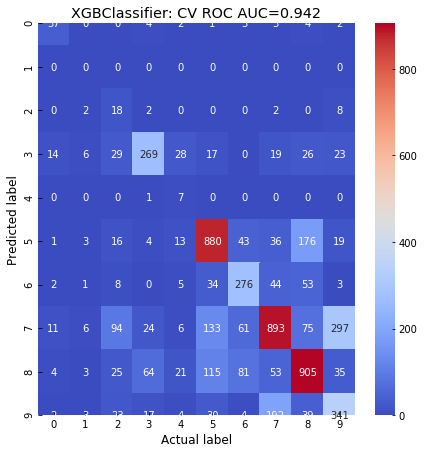

In [118]:
from xgboost import XGBClassifier

X, y = prepare_data(one_hotted=False)

xgb = XGBClassifier(random_state = RS) # XGBClassifier: CV ROC AUC=0.942

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25)

xgb.fit(X_train, y_train)

y_pred = xgb.predict_proba(X_cv)

df_predictions = pd.DataFrame(
    y_pred,
    index=y_cv.index,
    columns=[
        'fire_{}_prob'.format(class_id)
        for class_id in xgb.classes_
    ]
)

y_hotted = get_one_hot( y_cv )
draw_confusion_matrix(y_hotted, df_predictions, xgb)

## GradientBoostingClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


GradientBoostingClassifier: CV ROC AUC=0.940


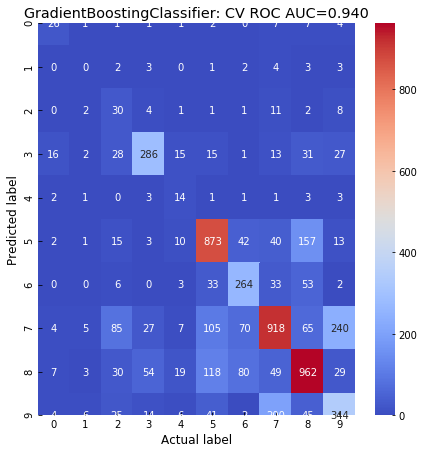

In [0]:
X, y = prepare_data(one_hotted=False)

gb_params = {'criterion': 'friedman_mse', 
             'learning_rate': 0.017498788653375064, 
             'max_depth': 3, 
             'max_features': 'sqrt', 
             'min_samples_leaf': 0.0628844140248267, 
             'min_samples_split': 15, 
             'n_estimators': 481, 
             'subsample': 0.8833752810065368,
             'random_state': RS
             } #0.5635

#gbc = skl.ensemble.GradientBoostingClassifier(**gb_params) # VotingClassifier: CV ROC AUC=0.885
gbc = skl.ensemble.GradientBoostingClassifier(random_state = RS) # GradientBoostingClassifier: CV ROC AUC=0.940

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25)

gbc.fit(X_train, y_train)

y_pred = gbc.predict_proba(X_cv)

df_predictions = pd.DataFrame(
    y_pred,
    index=y_cv.index,
    columns=[
        'fire_{}_prob'.format(class_id)
        for class_id in gbc.classes_
    ]
)

y_hotted = get_one_hot( y_cv )
draw_confusion_matrix(y_hotted, df_predictions, gbc)

## Вычисление финального значения

## Воутинг

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


VotingClassifier: CV ROC AUC=0.945


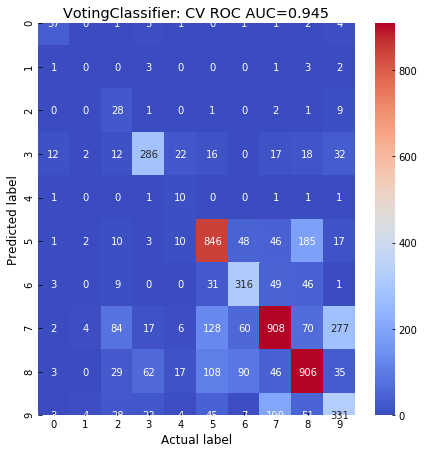

In [121]:
import sklearn.ensemble
from xgboost import XGBClassifier

X, y = prepare_data(one_hotted=False)

gb_params = {'criterion': 'friedman_mse', 
             'learning_rate': 0.017498788653375064, 
             'max_depth': 3, 
             'max_features': 'sqrt', 
             'min_samples_leaf': 0.0628844140248267, 
             'min_samples_split': 15, 
             'n_estimators': 481, 
             'subsample': 0.8833752810065368,
             'random_state': RS
             } #0.5635

gbc = skl.ensemble.GradientBoostingClassifier(random_state=RS)
xgb = XGBClassifier(random_state = RS)
abc = skl.ensemble.AdaBoostClassifier(random_state=RS)

eclf = skl.ensemble.VotingClassifier(estimators=[('gbc', gbc), ('xgb', xgb), ('abc', abc)], 
                                     voting='soft', 
                                     weights=[1, 2, 1]
                                     )
'''
[('gbc', gbc), ('xgb', xgb), ('abc', abc)]
[2, 2, 1] 0.945
[1, 2, 1] 0.945
'''

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25)

eclf.fit(X_train, y_train)

y_pred = eclf.predict_proba(X_cv)

df_predictions = pd.DataFrame(
    y_pred,
    index=y_cv.index,
    columns=[
        'fire_{}_prob'.format(class_id)
        for class_id in eclf.classes_
    ]
)
'''
VotingClassifier: CV ROC AUC=0.953
'''
y_hotted = get_one_hot( y_cv )
draw_confusion_matrix(y_hotted, df_predictions, eclf)

In [0]:
feat_importances = pd.Series(linear.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Основной блок

In [0]:
def get_callbacks():
  lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.5, patience=49)
  #early_stop = keras.callbacks.EarlyStopping( patience=100, monitor='val_auc', mode='max' ) #, restore_best_weights=True)
  early_stop = keras.callbacks.EarlyStopping( patience=100, monitor='val_loss', mode='min' )
  model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
            
  return [ early_stop, 
          model_save, 
          #TensorBoard(log_dir='.'),
          #lr_schedule 
          ]

In [0]:
'''  
  model = keras.Sequential([
      layers.Input(shape=[feature_num]),
      layers.Reshape(target_shape=[1, feature_num]),
      layers.LSTM(12, activation='relu', kernel_initializer='random_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)),
      #layers.LSTM(14, return_sequences=True),
      #layers.LSTM(14),
      layers.Dense(fire_type_num, kernel_initializer='random_uniform', activation='softmax'),
    ])
'''


def get_model( feature_num, fire_type_num ):
  weight_decay = 0.0005
  model = keras.Sequential([
      layers.Input(shape=[feature_num]),
      layers.Dense(128), #kernel_regularizer=keras.regularizers.l1_l2(0.03, 0.03)),
      #layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(64),
      layers.Dropout(0.2),
      layers.Dense(32),
      layers.Dropout(0.1),
      layers.Dense(fire_type_num, kernel_initializer='random_uniform', activation='softmax'),
    ])
  optimizer=keras.optimizers.RMSprop(lr=1e-2)
  model.compile(optimizer=optimizer, 
                metrics=[tf.keras.metrics.AUC(), 
                         tf.keras.metrics.categorical_accuracy
                         ], 
                loss=keras.losses.CategoricalCrossentropy() #tf.keras.losses.Huber())
                ) 

  model.summary()
  return model

In [0]:

tf.keras.backend.clear_session()

X, y = prepare_data(one_hotted=True)

EPOCHS = 1000
BS = 256
WINDOW = 0
FOLDS = 10
FEATURES_NUM = X.shape[1]
FIRE_TYPE_NUM = y.shape[1]

model = get_model(FEATURES_NUM, FIRE_TYPE_NUM)
callbacks = get_callbacks()

folds = list(skl.model_selection.KFold(n_splits=FOLDS, shuffle=True, random_state=RS).split(X, y))
for j, (train_idx, val_idx) in enumerate(folds):

  tr_data, cv_data = X.iloc[train_idx], X.iloc[val_idx]
  y_trn, y_cv = y.iloc[train_idx], y.iloc[val_idx]

#if True:
#  tr_data, cv_data, y_trn, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

  center, scale = tr_data.mean().values, tr_data.std().values
  trn = (tr_data.values - center)/scale
  cvn = (cv_data.values - center)/scale

  center.tofile('center.bin')
  scale.tofile('scale.bin')

  model.reset_states()
  history = model.fit(trn, y_trn.values,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            use_multiprocessing=True,
            verbose=0,
            validation_data=(cvn, y_cv.values),
            callbacks=callbacks)
  model = keras.models.load_model('my_checkpoint.h5')

  plot_history(history)

  score = model.evaluate(trn, y_trn.values, 
                          batch_size=BS, 
                          verbose=0,
                          use_multiprocessing=True)
  
print('loss: {:.3f}, AUC: {:.3f} Cat.Acc.: {:.3f}'.format(*score))

#model = tf.keras.models.load_model('my_checkpoint.h5')
model.reset_states()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8704      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3

loss: 1.167, AUC: 0.932 Cat.Acc.: 0.589
tr: ROC AUC=0.933
cv: ROC AUC=0.924
Sequential: CV ROC AUC=0.924


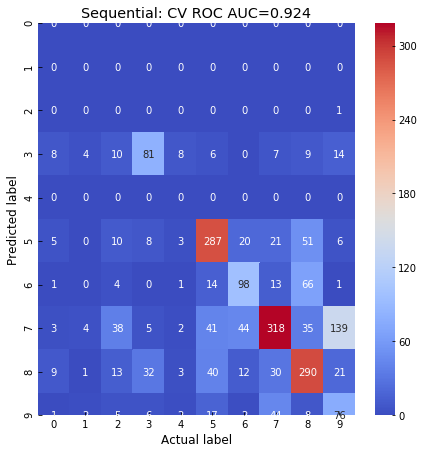

In [110]:
tr_data, cv_data, y_trn, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

trn = (tr_data.values - center)/scale
cvn = (cv_data.values - center)/scale

tr_preds = pd.DataFrame(model.predict(trn, use_multiprocessing=True), index=y_trn.index, columns=y_trn.columns)
cv_preds = pd.DataFrame(model.predict(cvn, use_multiprocessing=True), index=y_cv.index, columns=y_cv.columns)

score = model.evaluate(trn, y_trn.values, 
                         batch_size=BS, 
                         verbose=0,
                         use_multiprocessing=True)
print('loss: {:.3f}, AUC: {:.3f} Cat.Acc.: {:.3f}'.format(*score))

auc_trn = skl.metrics.roc_auc_score(y_trn, tr_preds, average='micro')
auc_cv = skl.metrics.roc_auc_score(y_cv, cv_preds, average='micro')
print('tr: ROC AUC=%.3f' % (auc_trn))
print('cv: ROC AUC=%.3f' % (auc_cv))

draw_confusion_matrix( y_cv, cv_preds, model)

In [0]:
#df_features[TARGET].groupby(df_features[TARGET]).count() , index=

vals = [ y_cv.iloc[:,i].sum() for i in range(y_cv.shape[1]) ]
pd.DataFrame(vals, index=y_cv.columns, columns=['count']).plot.barh();
plt.title('Fire Type Counts in cv', y=1)

IndexError: ignored

In [0]:
#auc_cv = skl.metrics.roc_auc_score(y_cv, cv_preds)
print( cv_preds.iloc[0].sum() )
a = tr_preds.apply(lambda row: row.map(lambda e: 1 if e == row.max() else 0), axis = 1)
a, y_cv

1.0


(         fire_1_prob  fire_2_prob  ...  fire_10_prob  fire_11_prob
 fire_id                            ...                            
 138567             0            0  ...             0             0
 142911             0            0  ...             0             0
 155147             0            0  ...             0             0
 153210             0            0  ...             0             1
 147445             0            0  ...             0             0
 ...              ...          ...  ...           ...           ...
 145579             0            0  ...             0             0
 146406             0            0  ...             0             0
 147343             0            0  ...             0             0
 140644             0            0  ...             0             0
 149812             0            0  ...             0             0
 
 [1500 rows x 10 columns], fire_id
 142953     6
 150822    10
 142310     9
 137261    10
 141065    11
         

In [0]:
all_pred = pd.DataFrame(model.predict(trn, use_multiprocessing=True), index=y_trn.index, columns=y_trn.columns)

draw_confusion_matrix(y_trn, all_pred)

TypeError: ignored

In [0]:
df_features[TARGET].groupby(df_features[TARGET]).count().plot.barh()

NameError: ignored

Test loss: 1.6663
Test accuracy: 0.1546


Text(0, 0.5, 'predicted activity')

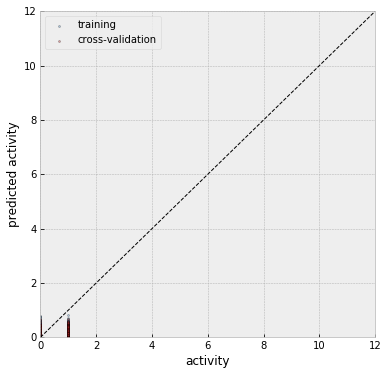

In [0]:
score = model.evaluate(trn, y_trn.values, verbose=0)
print('Test loss: {:.4f}'.format(score[0]))
print('Test accuracy: {:.4f}'.format(score[1]))

plt.scatter(y_trn.values, tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(y_cv.values, cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(0, 12)
plt.ylim(0, 12)
plt.legend(loc=0)
plt.plot([0, 12], [0, 12], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [106]:
for i in range(5):
  ind = np.int( np.random.random_sample() * tr_preds.shape[0] )
  print( tr_preds.iloc[ind].argmax(), y.iloc[ind].argmax() )

NameError: ignored

## Решение для отправки в систему

In [0]:
import pickle

with open('model.pickle', 'wb') as fout:
    pickle.dump(eclf, fout, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
df_predictions.insert (6, 'fire_7_prob', 0.0)
df_predictions.to_csv('sample_predictions.csv', index_label='fire_id')